# Introduction to Deep Learning

In this tutorial, we will present some of the basic concept of what is a neuron, neural network and how to train it for some task like classification or regression.

Let's dive in.

This tutorial is (almost completely) inspired from this [online book](http://neuralnetworksanddeeplearning.com) which I found is a gold mine if you want to understand how neural networks work and how they are implemented.

## Perceptrons and Sigmoid Neuron

The perceptron (or single neuron) is the common ancestor of all deep learning.

A perceptron takes several binary inputs, x1,x2,…, and produces a single binary output:

![a perceptron](http://neuralnetworksanddeeplearning.com/images/tikz0.png)

The idea of the perceptron is that it will activate itself based on a composition of its inputs and its internal weights.
In fact, each input $x_{j}$ has a corresponding weight $w_{j}$ that will control how relevant the input is for the decision process. 

The most basic way to do this is to use a sum and threshold:

$$
\left\{
\begin{array}{l}
0 \quad if \sum_{j}w_{j}x_{j} \leq threshold\\
1 \quad if \sum_{j}w_{j}x_{j}  > threshold
\end{array}
\right.
$$

By changing the value of each weight, you can change how the decision process will be done.
In the context of neural networks, the step function, $if \leq threshold$, is the called an activation function.

Now, we will have to do some modification to this perceptron in order for it to be useful.
Indeed, the secret magic sauce of training algorithm of deep learning architecture is the ability to construct models that are fully differentiable in respect to its ouput.
However, you can see here that the use of the step function, $if \leq threshold$ is totally not differentiable.

First of all, let's simplify the use of a threshold by using a bias and recenter the steps function around 0:

$$
\left\{
\begin{array}{l}
\sigma(x) = \sum_{j}w_{j}x_{j} + b\\
1 \quad if \sum_{j}w_{j}x_{j} + b > 0
\end{array}
\right.
$$

Next, let's change the activation function to the sigmoid function $\sigma(x) = {1 \over {1 + e^{-x}}}$ in order for it to be differentiable:

$$\sigma(\sum_{j}w_{j}x_{j} + b)$$

This now is not called a perceptron anymore, but a *sigmoid neuron* or *logistic neuron*.

But enough theory, let's do some practice by implementing this perceptron in tensorflow!

In [1]:
# first let's import all that we will need
%matplotlib inline
import tensorflow as tf
from itertools import product
import numpy as np
import matplotlib.pyplot as plt

/udd/kchoi/igrida/miniconda/envs/gpu/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Oversimplified, tensorflow is at its core a tensor library with automatic differentiation.
A *tensor* is a sort of vector, in the mathematical sense, where the important part is to define its size (or shape) and type.
One interesting aspect of a tensor is that the data that will flow through this tensor can be fed after the tensor is created.

With tensors, you can then do any kind of mathematical operations you want.
Every mathematical operations will then produce a new tensor, where it will store its results, that can be then reused to compose with more operations.

In [2]:
# Let's code a neuron that will do the NAND logical function
# This neuron will have two inputs, so a tensor x of size 2
def neuron(input_size, weights, bias):
    # tf.placeholder are how we define input tensor. Later, we will be able to fed our data into these tensors
    x = tf.placeholder(tf.float32, input_size)
    # It will also have two weights
    w = tf.Variable(weights, dtype=tf.float32)
    # And a bias
    b = tf.Variable(bias, dtype=tf.float32)
    # we use tf.Variable to notify tensorflow that these tensors are tensors that will be learned during training

    # Now let's implement the weighted sum + bias
    weighted_sum = tf.reduce_sum(x * w) + b
    # Next, we apply the sigmoid
    neuron_output = tf.sigmoid(weighted_sum)
    return neuron_output, [x, w, b, weighted_sum]

neuron_output, [x, w, b, weighted_sum] = neuron(2, [-2, -2], 3)
print("x:", x)
print("w:", w)
print("b:", b)
print("weighted sum:", weighted_sum)
print("neurone_output:", neuron_output)

x: Tensor("Placeholder:0", shape=(2,), dtype=float32)
w: <tf.Variable 'Variable:0' shape=(2,) dtype=float32_ref>
b: <tf.Variable 'Variable_1:0' shape=() dtype=float32_ref>
weighted sum: Tensor("add:0", shape=(), dtype=float32)
neurone_output: Tensor("Sigmoid:0", shape=(), dtype=float32)


In [3]:
# Now let's do some computation on the gpu!

# By default, tensorflow allocate all the memory of the gpu.
# For the need of the tutorial, we will only allocated what we need so that everybody can use a gpu
# Keep in mind that in real utilization, it is better to allocated all the memory of a gpu
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
# a tf.Session object will allow us to run computation on the gpu by specifying both a tensor to evaluate and data to evaluate with
sess = tf.Session(config=config)
# Next two line will initiliaze all variables like weights and biases
init = tf.global_variables_initializer()
sess.run(init)

In [4]:
# We can run computation with sess.run(tensor_to_compute, feed_dict={input_tensor: input_data})
def NAND(x1, x2, neuron_output):
    return sess.run(neuron_output, feed_dict={x: [x1, x2]})

for x1, x2 in product([0., 1.], repeat=2):
    print(x1, x2, NAND(x1, x2, neuron_output))

0.0 0.0 0.95257413
0.0 1.0 0.7310586
1.0 0.0 0.7310586
1.0 1.0 0.26894143


Well, it's not exactly the output we wanted, but that's what you get for manually tuning your weights.

Next, we'll get something out of the way: the batch.
For now, we can only feed one example at a time to our neurone.
Keep in mind that transfering data to the gpu is very time consuming, and that you can take advantage of the special architecture of the gpu in order to parallelize the computation of multiple examples.
So by processing examples in batch, we will be faster than computing each example one at a time.

In [5]:
# Here, we'll modify our neuron so that it can take a batch of example as input
def neuron_batch(batch_size, input_size, weights, bias):
    # tf.placeholder are how we define input tensor. Later, we will be able to fed our data into these tensors
    x = tf.placeholder(tf.float32, [batch_size, input_size])
    # It will also have two weights
    w = tf.Variable(weights, dtype=tf.float32)
    # And a bias
    b = tf.Variable(bias, dtype=tf.float32)
    # we use tf.Variable to notify tensorflow that these tensors are tensors that will be learned during training

    # Now let's implement the weighted sum + bias
    weighted_sum = tf.reduce_sum(x * w, axis=1) + b
    # Next, we apply the sigmoid
    neuron_output = tf.sigmoid(weighted_sum)
    return neuron_output, [x, w, b, weighted_sum]

# here we use a fixed batch size of 4
neuron_output, [x, w, b, weighted_sum] = neuron_batch(4, 2, [-2, -2], 3)
# you can also put None in order to have a variable batch size
neuron_output, [x, w, b, weighted_sum] = neuron_batch(None, 2, [-2, -2], 3)
init = tf.global_variables_initializer()
sess.run(init)

In [6]:
# so now we can process all examples in one sess.run call
sess.run(neuron_output, feed_dict={x: [[x1, x2] for x1, x2 in product([0., 1.], repeat=2)]})

array([0.95257413, 0.7310586 , 0.7310586 , 0.26894143], dtype=float32)

### Summary

A neuron of $k$ inputs is a small decision unit constituted of:

* a vector of shape $[k]$ of inputs
* a vector of shape $[k]$ of weights
* a bias
* an activation function
    * if it is the step function, it's a *Perceptron*, it's not trainable
    * if it is the sigmoid function, it's a *sigmoid* or a *logistic* neuron, and it's *trainable*
* processessing examples in batch is faster

## Multi-Layered Perceptron (MLP)

To have a more complex model that can do more usefull things, we can stack multiple neurons in parallel in order to make a *layer* of neurons.
Then, when to connect multiple layers one after the other, you obtain what we call a Multi-Layered Perceptrons or MLP.

*WARNING*! Keep in mind that, even though we use Perceptron here, if you want to train this network, you will have to use a Sigmoid neuron or any kind of trainable neuron.

![a 3 layer MLP](http://neuralnetworksanddeeplearning.com/images/tikz11.png)

Let's implement an MLP in ternsorflow!

In [75]:
def build_neuron_layer(input_tensor, num_neuron, last_layer=False):
    """
    input_tensor: tensor with shape [batch_size, input_size]
    num_neuron: number of neurons in the layer, also the output_size
    Here, we will use a random distribution in order to initialize weights and biases
    """
    # you now have number of inputs * number of neurons weights
    weights = tf.Variable(tf.random_normal(tf.TensorShape([input_tensor.shape[1], num_neuron])))
    # you have one bias per neurons
    biases = tf.Variable(tf.random_normal([num_neuron]))
    # you can do the weighted sum using a matrix multiplication
    weighted_sum = tf.matmul(input_tensor, weights)
    # then add biases
    add_biases = tf.add(weighted_sum, biases)
    # apply the activation function
    if not last_layer:
        layer_output = tf.sigmoid(add_biases)
    else:
        layer_output = add_biases
    return layer_output, [weights, biases]

def build_mlp(batch_size, input_size, layer_shapes):
    """
    batch_size: size of the batch, can be None for variable batch size
    input_size: input size of the placeholder input tensor
    layer_shapes: list of int, for example [2, 3, 1]
        Here there are 3 layers (2 hidden layers and 1 output layer) of respective shape 2, 3, and 1
    """
    x = tf.placeholder(tf.float32, [batch_size, input_size])
    layers = [x]
    variables = []
    for i, size in enumerate(layer_shapes):
        is_last_layer = i == (len(layer_shapes) - 1)
        layer, variable = build_neuron_layer(layers[-1], size, is_last_layer)
        layers.append(layer)
        variables.append(variable)
    return layers[-1], layers, variables

network_output, layers, variables = build_mlp(None, 3, [4, 1])
print("network_output:", network_output)
print("network layers:", layers)
print("network weights and biases:", variables)

network_output: Tensor("Add_33:0", shape=(?, 1), dtype=float32)
network layers: [<tf.Tensor 'Placeholder_37:0' shape=(?, 3) dtype=float32>, <tf.Tensor 'Sigmoid_30:0' shape=(?, 4) dtype=float32>, <tf.Tensor 'Add_33:0' shape=(?, 1) dtype=float32>]
network weights and biases: [[<tf.Variable 'Variable_74:0' shape=(3, 4) dtype=float32_ref>, <tf.Variable 'Variable_75:0' shape=(4,) dtype=float32_ref>], [<tf.Variable 'Variable_76:0' shape=(4, 1) dtype=float32_ref>, <tf.Variable 'Variable_77:0' shape=(1,) dtype=float32_ref>]]


## (Stochastic) Gradient Descent

As I said earlier, the secret magic sauce of Deep Learning training algorithm is the Gradient Descent algorithm.
The Gradient Descent algorithm works on one example at a time.
Instead, the Stochastic Gradient Descent works on a *mini-batch* of examples at a time.

The goal of a training algorithm is to tune the weights and biases in order to minimize a *cost function*.
A cost function is a function that tells us how good or bad we are doing.
You can see the cost function as a distance computation between the output of our neurone and the real value we wanted our network to output.
Traditionnally, the quadratic cost function, also called Mean Squared Error (MSE) is used in gradient descent tutorial because it's super easy to differentiate:

$$
C(w, b) = {1 \over 2n} \sum_{x}\|real\_output(x) - network\_output(x)\|^{2}
$$

Here, $w$ denotes the collection of all weights in the network, $b$ all the biases, $n$ is the total number of training inputs, $network\_output(x)$ is the vector of outputs from the network when $x$ is input, and the sum is over all training inputs, $x$.

In order to visualize how gradient descent works, imagine you have two weights: $v_{1}$ and $v_{2}$.
When using the MSE cost function, you can visualize it as a convexe plane where you want to find the minimum of this plane.

![visualization of the quadratic function](http://neuralnetworksanddeeplearning.com/images/valley.png)

Imagine that the current state of your network (with all of its weights and biases) is represented by a point on this plane.
If you can compute the gradient for all weights and biases, you then know in which direction to go in order to find the minimum of this plane.

![gradient descent](http://neuralnetworksanddeeplearning.com/images/valley_with_ball.png)

You just need to substract the gradients to your weights and biases and you will obtain and slightly better model than before.
One important parameter here is called the *learning rate*.
The *learning rate* is a number by which we will multiply the gradients before applying them to the weights.
Having a big *learning rate* means that you will learn faster, but you have a risk of missing the minimum point and "going to far".
Having a small *learning rate* means that you will learn slower, but you are "quite" sure that you won't miss the minimum point.

# Training for Regression

Let's train a neural network to approximate a function like $cos$.
Neural Networks are known to be *Universal Approximator*.
This means that with a network of only 1 hidden layer, you can approximate *any* function you want.
The only matter is that we don't know how many neurons in that layer is needed to approximate a given function.
It's a matter of experimentation to find the correct number of neurons in order to produce the precision you want, with the complexity you want.

In [87]:
def build_model_regression(batch_size, input_size, hidden_layer_size, output_size, learning_rate):
    network_output, layers, variables = build_mlp(batch_size, input_size, [hidden_layer_size, output_size])

    real_cos = tf.placeholder(tf.float32, [batch_size, input_size])
    cost = tf.losses.mean_squared_error(real_cos, network_output)
    train_ops = tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)
    return network_output, layers[0], real_cos, cost, train_ops

In [88]:
def get_cos_batch(batch_size, cos_range=[0, 2 * np.pi]):
    x = (np.random.rand(batch_size) * (cos_range[1] - cos_range[0])) + cos_range[0]
    # reshape as how the network is asking the input to be
    x = x.reshape([batch_size, 1])
    return x, np.cos(x)
get_cos_batch(4)

(array([[0.14152461],
        [2.46041363],
        [2.44419513],
        [4.25312064]]), array([[ 0.9900021 ],
        [-0.77683082],
        [-0.76651616],
        [-0.44329238]]))

In [116]:
# Let's do our training loop!
def train_regression(batch_size, input_size, hidden_layer_size, output_size, learning_rate,
          num_steps, print_frequency=10):
    network_output, network_input, real_cos, cost, train_ops = build_model_regression(
        None, input_size, hidden_layer_size, output_size, learning_rate
    )
    x = np.linspace(0, 2 * np.pi, 200)
    plt.plot(x, np.cos(x), linewidth=2)
    init = tf.global_variables_initializer()
    sess.run(init)
    for i in range(num_steps):
        batch_x, batch_real_cos = get_cos_batch(batch_size)
        sess.run(train_ops, feed_dict={network_input: batch_x, real_cos: batch_real_cos})
        if i % (num_steps // print_frequency) == 0:
            print("step:", i, "loss:", sess.run(cost, feed_dict={network_input: batch_x, real_cos: batch_real_cos}))
            plt.plot(
                x, 
                sess.run(network_output, feed_dict={network_input: np.expand_dims(x, axis=1)}),
                '--',
                linewidth=1,
                label="step {}".format(i))
    plt.plot(x, sess.run(network_output, feed_dict={network_input: np.expand_dims(x, axis=1)}),
             linewidth=2)
    plt.title("Comparison between real cos and our trained model")
    plt.show()

step: 0 loss: 1.0012071
step: 200 loss: 0.3319829
step: 400 loss: 0.16274151
step: 600 loss: 0.17327055
step: 800 loss: 0.053479217


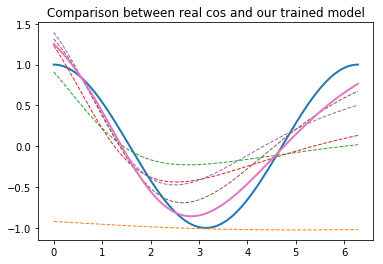

In [139]:
train_regression(
    batch_size=10,
    input_size=1,
    hidden_layer_size=4,
    output_size=1,
    learning_rate=0.1,
    num_steps=1000,
    print_frequency=5
)

## Classifying MNIST digits with keras

Softmax: https://fr.wikipedia.org/wiki/Fonction_softmax

categorical cross-entropy cost function: Measures the probability error in discrete classification tasks in which the classes are mutually exclusive (each entry is in exactly one class).

### using MLP

The code comes entirely from this keras examples: https://github.com/keras-team/keras/blob/master/examples/mnist_mlp.py

In [140]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import RMSprop

Using TensorFlow backend.


In [142]:
# Here we declare some hyperparameters
batch_size = 128
# we have 10 class of digits 0...9
num_classes = 10
# One epoch consists of one full training cycle on the training set.
# Once every sample in the set is seen, you start again - marking the beginning of the 2nd epoch.
epochs = 20

In [151]:
# loads the data
def load_mnist_mlp():
    # the data, split between train and test sets
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    plt.imshow(x_train[0], cmap='gray')
    plt.show()

    x_train = x_train.reshape(60000, 784)
    x_test = x_test.reshape(10000, 784)
    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')

    # convert class vectors to binary class matrices
    print("before categorical", y_train.shape)
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    print("before categorical", y_train.shape)
    return x_train, y_train, x_test, y_train

In [152]:
def build_mlp_classifier():
    model = Sequential()
    model.add(Dense(512, activation='relu', input_shape=(784,)))
    model.add(Dropout(0.2))
    model.add(Dense(512, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(num_classes, activation='softmax'))

    model.summary()

    model.compile(loss='categorical_crossentropy',
                  optimizer=RMSprop(),
                  metrics=['accuracy'])
    return model

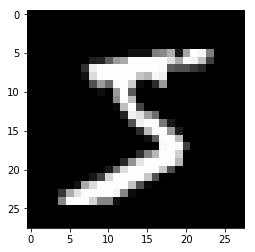

60000 train samples
10000 test samples
before categorical (60000,)
before categorical (60000, 10)
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 512)               401920    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 10)                5130      
Total params: 669,706
Trainable params: 669,706
Non-trainable params: 0
_________________________________________________________________
Train on 60000 samples, validate on 10

In [153]:
def train_mlp_classifier():
    x_train, y_train, x_test, y_train = load_mnist_mlp()
    model = build_mlp_classifier()
    history = model.fit(x_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(x_test, y_test))
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])

train_mlp_classifier()

### using MLP

The code comes entirely from this keras examples: https://github.com/keras-team/keras/blob/master/examples/mnist_cnn.py

In [154]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

In [155]:
batch_size = 128
num_classes = 10
epochs = 12

In [157]:
def load_mnist_cnn():
    # input image dimensions
    img_rows, img_cols = 28, 28

    # the data, split between train and test sets
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    if K.image_data_format() == 'channels_first':
        x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
        x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
        input_shape = (1, img_rows, img_cols)
    else:
        x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
        x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
        input_shape = (img_rows, img_cols, 1)

    x_train = x_train.astype('float32')
    x_test = x_test.astype('float32')
    x_train /= 255
    x_test /= 255
    print('x_train shape:', x_train.shape)
    print(x_train.shape[0], 'train samples')
    print(x_test.shape[0], 'test samples')

    # convert class vectors to binary class matrices
    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    return input_shape, x_train, y_train, x_test, y_train

In [165]:
def build_cnn_classifier(input_shape):
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    model.summary()
    return model

In [164]:
def train_cnn_classifier():
    input_shape, x_train, y_train, x_test, y_train = load_mnist_cnn()
    model = build_cnn_classifier(input_shape)
    model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(x_test, y_test))
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
train_cnn_classifier()

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Train on 60000 samples, validate on 10000 samples
Epoch 1/12
60000/60000 [==============================] - 14s 239us/step - loss: 0.2570 - acc: 0.9208 - val_loss: 0.0548 - val_acc: 0.9827
Epoch 2/12
60000/60000 [==============================] - 10s 163us/step - loss: 0.0836 - acc: 0.9756 - val_loss: 0.0390 - val_acc: 0.9867
Epoch 3/12
60000/60000 [==============================] - 10s 163us/step - loss: 0.0622 - acc: 0.9816 - val_loss: 0.0365 - val_acc: 0.9882
Epoch 4/12
60000/60000 [==============================] - 10s 165us/step - loss: 0.0517 - acc: 0.9846 - val_loss: 0.0332 - val_acc: 0.9889
Epoch 5/12
60000/60000 [==============================] - 10s 164us/step - loss: 0.0457 - acc: 0.9867 - val_loss: 0.0299 - val_acc: 0.9897
Epoch 6/12
60000/60000 [==============================] - 10s 164us/step - loss: 0.0400 - acc: 0.9881 - val_loss: 0.0270 - val_acc: 0.9905
Epoch 7/12
60000/60000 [===================